# 1 Evaluating IR systems

1.1. Index the pri cfc.txt1
collection (one document per line). You can use whoosh facilities

In [1]:
import os
import whoosh.index as index
from whoosh import fields

if not os.path.exists('index_ir'): os.mkdir('index_ir')
schema = fields.Schema(id=fields.NUMERIC(stored=True), content=fields.TEXT)
ix = index.create_in("index_ir", schema)

writer = ix.writer()

with open('pri_cfc.txt', 'r') as f:
    # 00001 The significance of Pseudomonas aeruginosa infection in the respiratory tract of 9 cystic fibrosis patients have been studied by means of immunoelectrophoretical analysis of patients' sera for the number of precipitins against Pseudomonas aeruginosa and the concentrations of 16 serum proteins.  In addition, the clinical and radiographical status of the lungs have been evaluated using 2 scoring systems.  Precipitins against Pseudomonas aeruginosa were demonstrated in all sera, the maximum number in one serum was 22. The concentrations of 12 of the serum proteins were significantly changed compared with matched control persons.  Notably IgG and IgA were elevated and the "acute phase proteins" were changed, the latter suggesting active tissue damage.  The concentrations of 3 of the acute phase proteins, notably haptoglobin, were correlated to the number of precipitins suggesting that the respiratory tract infection in patients with many precipitins is accompanied by more tissue damage than the infection in patients with few precipitins. The results indicate no protective value of the many precipitins on the tissue of the respiratory tract.
    # Get the first 00001 as id and the rest as content
    for line in f:
        id, content = line.split(' ', 1)
        print(f"Id={id}, content={content}")
        writer.add_document(id=int(id), content=content)

writer.commit()




Id=00001, content=The significance of Pseudomonas aeruginosa infection in the respiratory tract of 9 cystic fibrosis patients have been studied by means of immunoelectrophoretical analysis of patients' sera for the number of precipitins against Pseudomonas aeruginosa and the concentrations of 16 serum proteins.  In addition, the clinical and radiographical status of the lungs have been evaluated using 2 scoring systems.  Precipitins against Pseudomonas aeruginosa were demonstrated in all sera, the maximum number in one serum was 22. The concentrations of 12 of the serum proteins were significantly changed compared with matched control persons.  Notably IgG and IgA were elevated and the "acute phase proteins" were changed, the latter suggesting active tissue damage.  The concentrations of 3 of the acute phase proteins, notably haptoglobin, were correlated to the number of precipitins suggesting that the respiratory tract infection in patients with many precipitins is accompanied by more

1.2. Implement:
- precision
- recall 
- F1 measures. 
  
These functions take two simple inputs: 
- the set of retrieved document IDs
- the set of relevant document IDs

The formulas are:

$$
\text{precision} = \frac{\text{number of relevant documents retrieved}}{\text{number of documents retrieved}}
$$

$$
\text{recall} = \frac{\text{number of relevant documents retrieved}}{\text{number of relevant documents}}
$$

$$
\text{F1} = \frac{1}{\alpha \frac{1}{\text{precision}} + (1-\alpha) \frac{1}{\text{recall}}}
$$

In [2]:
def precision(retrieved_documents_ids, relevant_documents_ids):
    # print(f"Len relevant precision: {len(relevant_documents_ids)}")

    retrieved_and_relevant = len(set(retrieved_documents_ids).intersection(set(relevant_documents_ids)))
    return retrieved_and_relevant / len(retrieved_documents_ids)

def recall(retrieved_documents_ids, relevant_documents_ids):
    # print(f"Len relevant recall: {len(relevant_documents_ids)}")

    retrieved_and_relevant = len(set(retrieved_documents_ids).intersection(set(relevant_documents_ids)))
    return retrieved_and_relevant / len(relevant_documents_ids)

def f1_score(precision, recall, alpha=0.5):
    if precision == 0 or recall == 0:
        return 0
    
    return 1/(alpha/precision + (1-alpha)/recall)



1.3. The file pri queries.txt1 contains a set of queries and, for each query, the set of relevant documents.

For each of the first 10 queries, execute the corresponding search using two different
scoring criteria
- TF-IDF
- BM25.

In [3]:
queries = []

with open("pri_queries.txt", "r") as f:
    # What are the effects of calcium on the physical properties of mucus from CF patients?
    # 139 151 166 311 370 392 439 440 441 454 461 502 503 505 520 522 526 527 533 593 619 737 742 789 827 835 861 875 891 921 922 1175 1185 1222

    # We want to read 2 rows until we reach the end of the file
    # While we still have lines to read
    while True:
        query = f.readline().strip()
        if not query:
            break
        # Get the relevant documents
        relevant_documents = f.readline().strip().split(" ")
        # cast int
        relevant_documents = list(map(int, relevant_documents))
        # Add the query and relevant documents to the queries list
        queries.append((query, relevant_documents))
print(queries)

[('What are the effects of calcium on the physical properties of mucus from CF patients?', [139, 151, 166, 311, 370, 392, 439, 440, 441, 454, 461, 502, 503, 505, 520, 522, 526, 527, 533, 593, 619, 737, 742, 789, 827, 835, 861, 875, 891, 921, 922, 1175, 1185, 1222]), ('Can one distinguish between the effects of mucus hypersecretion and infection on the submucosal glands of the respiratory tract in CF?', [169, 434, 454, 498, 499, 592, 875]), ('How are salivary glycoproteins from CF patients different from those of normal subjects?', [23, 40, 139, 190, 221, 246, 309, 311, 325, 345, 347, 356, 370, 374, 375, 439, 440, 454, 515, 520, 524, 526, 527, 533, 535, 560, 561, 571, 584, 604, 623, 633, 733, 742, 854, 856, 950, 967, 1144, 1161, 1172, 1175, 1196]), ('What is the lipid composition of CF respiratory secretions?', [503, 538, 539, 540, 553, 604, 669, 711, 876]), ('Is CF mucus abnormal?', [23, 47, 50, 60, 114, 132, 135, 139, 151, 169, 189, 190, 197, 200, 226, 256, 265, 297, 298, 299, 311, 31

In [4]:
# For each of the first 10 queries, execute the corresponding search using tf-idf and BM25
from whoosh import scoring
from whoosh.qparser import QueryParser
from whoosh.qparser import OrGroup
def search_tf_idf(query, ix):
    with ix.searcher(
        weighting=scoring.TF_IDF()
    ) as searcher:
        q = QueryParser("content", ix.schema, group=OrGroup).parse(query)
        results = searcher.search(q)
        return [int(result['id']) for result in results]
    


    
def search_bm25(query, ix):
    with ix.searcher(
        weighting=scoring.BM25F(B=0.75, K1=1.2)
    ) as searcher:
        q = QueryParser("content", ix.schema, group=OrGroup).parse(query)
        results = searcher.search(q)
        return [int(result['id']) for result in results]

In [5]:
tf_idf_docs = []
bm25_docs = []

retrieved_stuff = {}
for query, relevant_documents in queries[:10]:

    retrieved_stuff[query] = {}
    tf_idf_docs = search_tf_idf(query, ix)
    bm25_docs = search_bm25(query, ix)
    retrieved_stuff[query]['tf_idf'] = tf_idf_docs
    retrieved_stuff[query]['bm25'] = bm25_docs

for k, v in retrieved_stuff.items():
    print(k)
    print(v)
    print()


What are the effects of calcium on the physical properties of mucus from CF patients?
{'tf_idf': [307, 856, 139, 526, 484, 441, 437, 961, 925, 754], 'bm25': [437, 533, 856, 568, 975, 957, 441, 392, 439, 499]}

Can one distinguish between the effects of mucus hypersecretion and infection on the submucosal glands of the respiratory tract in CF?
{'tf_idf': [761, 1197, 1170, 949, 980, 925, 1, 498, 744, 160], 'bm25': [980, 592, 754, 761, 733, 1, 511, 1197, 176, 1211]}

How are salivary glycoproteins from CF patients different from those of normal subjects?
{'tf_idf': [1206, 856, 956, 307, 961, 55, 959, 655, 749, 1197], 'bm25': [633, 1206, 856, 904, 150, 218, 805, 311, 1064, 959]}

What is the lipid composition of CF respiratory secretions?
{'tf_idf': [1197, 307, 961, 856, 956, 322, 726, 867, 1170, 749], 'bm25': [715, 1197, 928, 867, 725, 1039, 767, 856, 726, 568]}

Is CF mucus abnormal?
{'tf_idf': [307, 961, 925, 322, 749, 956, 754, 498, 260, 655], 'bm25': [754, 151, 975, 265, 867, 437, 564

1.4. Using the reference and produced results in 1.3, compare the performance of TF-IDF and
BM25 scoring criteria for the given collection with regards to precision, recall and F1. 

Print the
average score and standard deviation for each measure

In [6]:
# 1.4. Using the reference and produced results in 1.3, compare the performance of TF-IDF and
# BM25 scoring criteria for the given collection with regards to precision, recall and F1. 

# Print the
# average score and standard deviation for each measure

import numpy as np

precision_tf_idf = []
recall_tf_idf = []
f1_tf_idf = []

precision_bm25 = []
recall_bm25 = []
f1_bm25 = []

for query, relevant_documents in queries[:10]:
    tf_idf_docs = retrieved_stuff[query]['tf_idf']
    bm25_docs = retrieved_stuff[query]['bm25']

    precision_tf_idf.append(precision(tf_idf_docs, relevant_documents))
    recall_tf_idf.append(recall(tf_idf_docs, relevant_documents))

    # print(f"Relevant documents: {relevant_documents}")
    # print(f"TF-IDF: {tf_idf_docs}")
    # print(f"BM25: {bm25_docs}")

    f1_tf_idf.append(f1_score(precision_tf_idf[-1], recall_tf_idf[-1]))

    precision_bm25.append(precision(bm25_docs, relevant_documents))
    recall_bm25.append(recall(bm25_docs, relevant_documents))
    f1_bm25.append(f1_score(precision_bm25[-1], recall_bm25[-1]))

    # print(f"Precision TF-IDF: {precision_tf_idf[-1]}")
    # print(f"Recall TF-IDF: {recall_tf_idf[-1]}")
    # print(f"F1 TF-IDF: {f1_tf_idf[-1]}")

print("-------------------------")

print("TF-IDF")
print("Precision Mean Std:", np.mean(precision_tf_idf), np.std(precision_tf_idf))

print("Recall Mean Std:", np.mean(recall_tf_idf), np.std(recall_tf_idf))

print("F1 Mean Std:", np.mean(f1_tf_idf), np.std(f1_tf_idf))

print("BM25")
print("Precision Mean Std:", np.mean(precision_bm25), np.std(precision_bm25))

print("Recall Mean Std:", np.mean(recall_bm25), np.std(recall_bm25))

print("F1 Mean Std:", np.mean(f1_bm25), np.std(f1_bm25))


-------------------------
TF-IDF
Precision Mean Std: 0.15999999999999998 0.0916515138991168
Recall Mean Std: 0.07557842576696285 0.06100261586061127
F1 Mean Std: 0.09260032200383875 0.06308397920228391
BM25
Precision Mean Std: 0.29000000000000004 0.19209372712298547
Recall Mean Std: 0.10586851130233091 0.05877281770748112
F1 Mean Std: 0.13917125728184704 0.06990390364923463


1.5. Extend the evaluation criteria to further return the values that define the precision-recall
curve, as well as the subsequent Mean Average Precision (MAP) statistic.

 You can either assess
precision for each relevant document or directly use sklearn.metrics.precision recall curve

[(0.3, 0.08823529411764706), (0.1, 0.14285714285714285), (0.1, 0.023255813953488372), (0.0, 0.0), (0.2, 0.015267175572519083), (0.3, 0.125), (0.1, 0.03571428571428571), (0.1, 0.045454545454545456), (0.2, 0.2), (0.2, 0.08)]
[(0.4, 0.11764705882352941), (0.1, 0.14285714285714285), (0.3, 0.06976744186046512), (0.0, 0.0), (0.7, 0.05343511450381679), (0.4, 0.16666666666666666), (0.4, 0.14285714285714285), (0.1, 0.045454545454545456), (0.2, 0.2), (0.3, 0.12)]


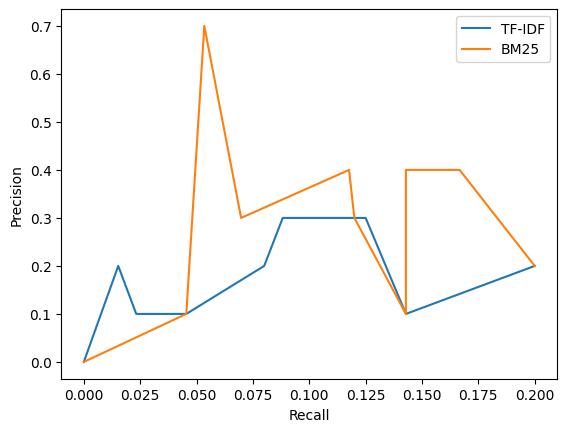

In [7]:
# 1.5. Extend the evaluation criteria to further return the values that define the precision-recall
# curve, as well as the subsequent Mean Average Precision (MAP) statistic.

# Sort documents by recall in ascending order

tf_idf_pairs = []
bm25_pairs = []

for i in range(10):
    tf_idf_pairs.append((precision_tf_idf[i], recall_tf_idf[i]))
    bm25_pairs.append((precision_bm25[i], recall_bm25[i]))

print(tf_idf_pairs) 
print(bm25_pairs) 

# Let's sort it
tf_idf_pairs = sorted(tf_idf_pairs, key=lambda x:x[1])
bm25_pairs = sorted(bm25_pairs, key=lambda x:x[1])

# Use matplot lib to plot the precision-recall curve using the sorted pairs and the recall as x and precision as y
import matplotlib.pyplot as plt

tf_idf_pairs = np.array(tf_idf_pairs)
bm25_pairs = np.array(bm25_pairs)

plt.plot(tf_idf_pairs[:, 1], tf_idf_pairs[:, 0], label="TF-IDF")

plt.plot(bm25_pairs[:, 1], bm25_pairs[:, 0], label="BM25")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()




In [8]:
sum = 0
for i in tf_idf_pairs:
    sum = sum + i[0]
print(sum / len(tf_idf_pairs))

print("MAP")

0.16
MAP


# 2 LLM Embeddings using BERT

2.1. Before learning large language model embeddings, let us first look to the TF-IDF vectors
for the pri cfc.txt collection. Using sklearn.feature extraction.text.TfidfVectorizer(), compute
the TF-IDF vectors for the documents in the collection.

In [9]:
# tf-idf vector

from sklearn.feature_extraction.text import TfidfVectorizer

documents = []
with open('pri_cfc.txt', 'r') as f:
    for line in f:
        id, content = line.split(' ', 1)
        documents.append(content)

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(documents)

print(X.shape)

(1239, 9987)


2.2. Let us visualize the proximity of documents based on their TF-IDF vectors by reducing
the dimensionality of the vector space to 2 dimensions. To this end, we can use PCA, tSNE or
other dimensionality reduction technique. Consider applying uMAP2 using the following code.

d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

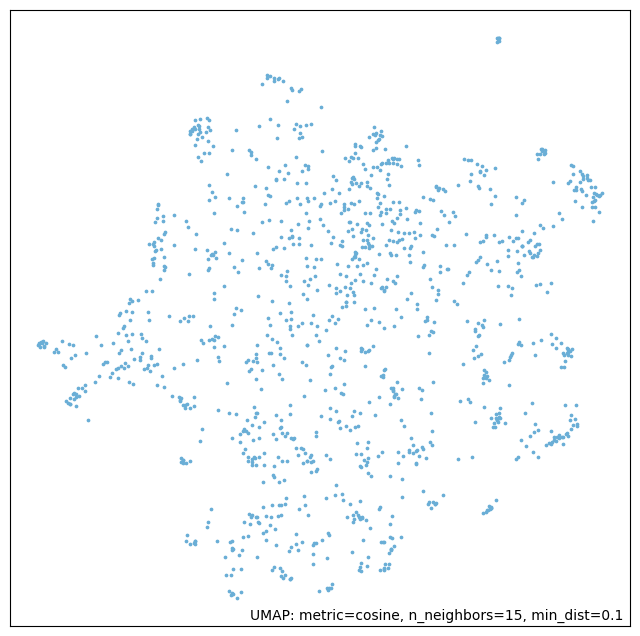

In [10]:
import umap, umap.plot
# use umap to plot the tf-idf vectors in 2D

reducer = umap.UMAP(n_neighbors=15, metric='cosine')
embedding = reducer.fit_transform(X)

umap.plot.points(reducer)


2.3 BERT

In [27]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

params = [p.numel() for p in bert_model.parameters()]

# Sum the number of parameters
sum = 0
for p in params:
    sum += p

print(sum)
print(bert_model.eval())

109482240
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

In [39]:
import torch

def get_bert_output(tokenizer, model, sentence, mode='cls', optype='sumsum'):
    tokenized_text = tokenizer.tokenize(sentence)
    tokens_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    segments_tensors = torch.tensor([[1] * len(tokenized_text)])
    outputs = model(tokens_tensor, segments_tensors)
    if mode == 'cls': embedding = outputs['last_hidden_state'].squeeze()[0]
    elif mode == 'pooled': embedding = outputs['pooler_output'].squeeze()
    else: #‘hidden’
        layers = torch.stack(outputs['hidden_states'][-4:])
        if optype == 'sumsum': embedding = torch.sum(layers.sum(0).squeeze(), dim=0)
        elif optype == 'summean': embedding = torch.sum(layers.mean(0).squeeze(), dim=0)
        elif optype == 'meanmean': embedding = torch.mean(layers.mean(0).squeeze(), dim=0)
        else: embedding = torch.mean(layers.sum(0).squeeze(), dim=0)
    return embedding.detach().numpy()

# Get the output of the bert model
bert_outputs = []

for document in documents[:300]:
    bert_outputs.append(get_bert_output(tokenizer, bert_model, document))

print(bert_outputs)

[array([ 1.63575143e-01,  1.43555254e-01, -1.18648633e-01,  3.04926157e-01,
        2.37259120e-01, -1.02885790e-01, -3.27550411e-01, -3.71344179e-01,
        8.18014443e-02, -1.81367457e-01,  2.08714530e-01,  1.95570692e-01,
       -1.31994709e-01,  2.23382518e-01, -1.79124132e-01,  4.78477031e-01,
       -2.14077935e-01, -8.42493102e-02, -1.54850874e-02, -8.46740156e-02,
        2.85705835e-01, -4.65316862e-01,  1.90912843e-01, -4.73944634e-01,
        7.06664473e-02, -2.00660825e-01, -1.43858671e-01, -3.29794496e-01,
       -1.14837527e-01, -2.40825772e-01,  3.81865017e-02,  3.74642104e-01,
       -1.43102467e-01,  9.19663981e-02, -5.11889830e-02,  7.60169923e-02,
        7.34788254e-02,  9.70132500e-02,  8.99802968e-02, -3.31290960e-01,
       -1.38937682e-01,  2.98297971e-01, -3.90513867e-01,  2.82730967e-01,
        1.14243314e-01,  2.60248899e-01, -1.38774765e+00, -3.65742356e-01,
        1.67513683e-01,  8.40101391e-03,  2.59745419e-01, -2.13808119e-02,
        2.59047836e-01, 

d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)
d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1],

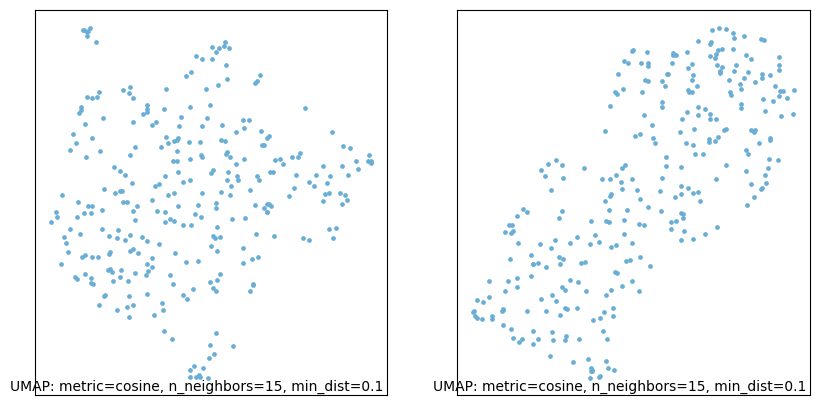

In [40]:
# Visualize in 2 graph side by side usign umap tfidf and bert outputs for the first 300 documents
reducer = umap.UMAP(n_neighbors=15, metric='cosine')

# Split 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the tfidf
embedding = reducer.fit_transform(X[:300])
umap.plot.points(reducer, ax=axs[0])

# Plot the bert
embedding = reducer.fit_transform(bert_outputs)
umap.plot.points(reducer, ax=axs[1])

plt.show()